In [186]:
import requests
import pandas as pd
from tqdm import tqdm
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
url_inventory_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
url_stations_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url_countries_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
url_states_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt"
url_state_raw = "https://raw.githubusercontent.com/georgique/world-geojson/develop/states/usa/new_hampshire.json"

In [188]:
def parse_stations_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEVATION": float(line[31:37].strip()),
                "STATE": line[38:40].strip(),
                "NAME": line[38:68].strip(),
            })
    return pd.DataFrame(data)

def parse_inventory_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEMENT": line[31:35].strip(),
                "FIRSTYEAR": int(line[36:40].strip()),
                "LASTYEAR": int(line[41:45].strip())
            })
    return pd.DataFrame(data)

def parse_countries_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:64].strip()
            })
    return pd.DataFrame(data)

def parse_states_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:50].strip()
            })
    return pd.DataFrame(data)

def parse_data_dly(line):
    data = []
    for i in range(21, 269, 8):
        value = int(line[i:i+5])
        mflag = line[i+5]
        qflag = line[i+6]
        sflag = line[i+7]
        data.extend([value, mflag, qflag, sflag])
    return {
        "ID": line[0:11].strip(),
        "YEAR": int(line[11:15]),
        "Month": int(line[15:17]),
        "ELEMENT": line[17:21].strip(),
        "DATA": data
    }

def read_data_from_url(url):
    data = []
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.splitlines():
            data.append(parse_data_dly(line))
    else:
        print(f"Failed to retrieve data for {url}. Status code: {response.status_code}")
    return data

def fetch_and_save_to_dataframe(station_ids):
    all_data = []
    for station_id in tqdm(station_ids, desc="Fetching Data", unit="station", ncols=100):
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly"
        data = read_data_from_url(url)
        all_data.extend(data)
    headers = ["ID", "YEAR", "Month", "ELEMENT"]
    for i in range(1, 32):
        headers.extend([f"VALUE{i}", f"MFLAG{i}", f"QFLAG{i}", f"SFLAG{i}"])
    df_data = []
    for entry in all_data:
        row = [entry["ID"], entry["YEAR"], entry["Month"], entry["ELEMENT"]]
        row.extend(entry["DATA"])
        df_data.append(row)
    return pd.DataFrame(df_data, columns=headers)


In [189]:
inventory = parse_inventory_txt(url_inventory_txt)
stations= parse_stations_txt(url_stations_txt)
countries = parse_countries_txt(url_countries_txt)
states = parse_states_txt(url_states_txt)

In [190]:
# For country
#s_country_list = stations[stations['ID'].str.startswith('US')]['ID'].tolist()
# For state
s_state_list=stations[stations['STATE']=='NH']['ID'].tolist()
s_live_list=inventory[(inventory['ID'].isin(s_state_list)) & (inventory['LASTYEAR']>=2024)]['ID'].unique().tolist()
result = inventory.loc[inventory['ID'].isin(s_live_list), ['ID', 'ELEMENT', 'FIRSTYEAR', 'LASTYEAR']]
result['YEAR_DIFF'] = result['LASTYEAR'] - result['FIRSTYEAR']
Req_station_list = pd.Series(result[(result['YEAR_DIFF'] >= 50) & (result['LASTYEAR'] > 2014)]['ID'].tolist()).unique()

In [191]:
data= fetch_and_save_to_dataframe(Req_station_list)

Fetching Data: 100%|███████████████████████████████████████████| 28/28 [00:13<00:00,  2.06station/s]


In [192]:
flag_columns = [col for col in data.columns if 'FLAG' in col]
data= data.drop(columns=flag_columns)
data.replace(-9999.0, np.nan, inplace=True)

In [194]:
weather_variables = ['TMAX', 'TMIN', 'SNOW', 'SNWD', 'PRCP', 'WT04', 'WT09', 'WT18']
data=data[data['ELEMENT'].isin(weather_variables)]

In [202]:
from collections import defaultdict
station_year_month = data.groupby(['ID', 'YEAR', 'Month']).size().reset_index(name='count')
missing_by_station = defaultdict(list)
stations_with_more_than_10_missing_years = []
for station in data['ID'].unique():
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    all_years = range(min_year, max_year)  
    all_months = range(1, 13)
    all_combinations = pd.MultiIndex.from_product([all_years, all_months], names=['YEAR', 'Month'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    station_data = station_year_month[station_year_month['ID'] == station]
    merged_data = pd.merge(all_combinations_df, station_data, on=['YEAR', 'Month'], how='left')
    missing_data = merged_data[merged_data['count'].isna()]
    missing_pairs = missing_data[['YEAR', 'Month']].itertuples(index=False, name=None)
    for pair in missing_pairs:
        missing_by_station[station].append((pair[0], pair[1]))

for station, pairs in missing_by_station.items():
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    years_missing = set([year for year, _ in pairs]) 
    months_missing = set([month for _, month in pairs])
    fully_missing_years = [year for year in years_missing if len(months_missing) == 12]
    if len(fully_missing_years) > 10:
        stations_with_more_than_10_missing_years.append(station)
stations_to_print = [station for station in missing_by_station.keys() if station not in stations_with_more_than_10_missing_years]


In [203]:
data=data[data['ID'].isin(stations_to_print)]

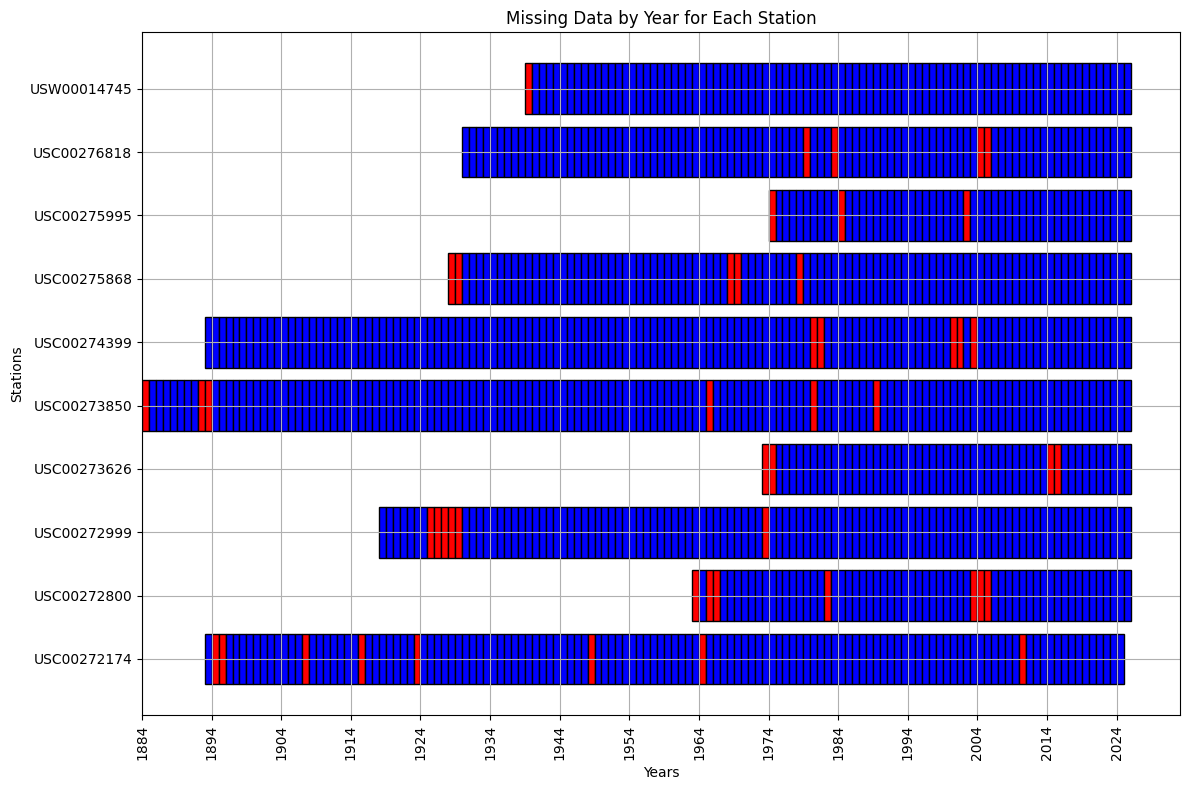

In [204]:
# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create a color map for missing data and available data
missing_color = 'red'
available_color = 'blue'

# Find the overall min and max year across all stations
min_overall_year = min([data[data['ID'] == station]['YEAR'].min() for station in stations_to_print])
max_overall_year = max([data[data['ID'] == station]['YEAR'].max() for station in stations_to_print])

# Loop over each station to create the plot
for idx, station in enumerate(stations_to_print):
    # Get the min and max years for the station
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()

    # Ensure min_year and max_year are different
    if min_year == max_year:
        continue

    # Generate a 2D grid for years (x-axis) and months (y-axis) if the years are valid
    if min_year < max_year:
        years = np.arange(min_year, max_year + 1)

        # Initialize a matrix to represent data availability (1 for missing data, 0 for available data)
        availability_matrix = np.zeros(len(years))

        # Mark missing year-month pairs
        for year, _ in missing_by_station.get(station, []):
            year_indices = np.where(years == year)
            if year_indices[0].size > 0:
                year_idx = year_indices[0][0]
                availability_matrix[year_idx] = 1  # Mark missing data as 1

        # Create bars for each year, marking missing data in red and available data in blue
        for i, year in enumerate(years):
            if availability_matrix[i] == 1:
                ax.barh(idx, 1, left=year, height=0.8, color=missing_color, edgecolor='black')
            else:
                ax.barh(idx, 1, left=year, height=0.8, color=available_color, edgecolor='black')

# Set labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Stations')
ax.set_title('Missing Data by Year for Each Station')

# Customize year labels on x-axis: show first, last, and every 10th year
x_ticks = [min_overall_year] + list(range(min_overall_year + 10, max_overall_year, 10)) 
ax.set_xticks(x_ticks)

# Customize station names on y-axis
ax.set_yticks(np.arange(len(stations_to_print)))
ax.set_yticklabels(stations_to_print)  # Use the stations_to_print list

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Add grid
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
state_stations = stations[stations['STATE']=='NH']
state_lat = state_stations['LATITUDE'].mean()
state_lon = state_stations['LONGITUDE'].mean()
state_map = folium.Map(location=[state_lat, state_lon], 
                       zoom_start=7.5,
                       min_zoom=6,
                       max_zoom=10)

stations_to_plot = stations[stations['ID'].isin(Req_station_list)]
for _, row in stations_to_plot.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['NAME'],
        tooltip=row['NAME']
    ).add_to(state_map)
try:
    geojson_data = requests.get(url_state_raw).json() 
    folium.GeoJson(geojson_data, name="State Boundary").add_to(state_map)
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    
state_map

In [234]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

import pandas as pd

def process_temperature(element, value):
    """Convert temperature (TMAX, TMIN) to Celsius."""
    if element == 'TMAX' or element == 'TMIN':
        return value / 10  # Convert tenths of C to whole C
    return None

def process_snow(element, value):
    """Process SNOW and SNWD values."""
    if element == 'SNOW':
        return value  # Keep snow in mm
    elif element == 'SNWD':
        return value  # Keep snow depth in mm
    return None

def process_precipitation(element, value):
    """Convert precipitation (PRCP) to mm."""
    if element == 'PRCP':
        return value / 10  # Convert tenths of mm to whole mm
    return None

def process_weather_type(element, value):
    """Handle various weather types."""
    # Define the weather types and their respective codes
    weather_types = {
        'WT04': 'WT04_Snow_Hail',
        'WT09': 'WT09_Blowing_Snow',
        'WT18': 'WT18_Snow'
    }
    
    # Check if the element matches any of the weather type codes
    if element in weather_types:
        return weather_types[element], value
    return None, None


def transform_weather_data(df):
    transformed_data = {}
    for index, row in df.iterrows():
        for day in range(1, 32):
            date = pd.to_datetime(f"{row['YEAR']}-{row['Month']:02d}-{day:02d}", errors='coerce')
            if pd.notna(date):
                if date not in transformed_data:
                    transformed_data[date] = {"ID": row['ID']}
                element = row['ELEMENT']
                value = row.get(f'VALUE{day}', None)
                if pd.notna(value) and value != -9999:
                    # Process weather types
                    weather_type_val, weather_type_column = process_weather_type(element, value)
                    if weather_type_val is not None:
                        transformed_data[date][weather_type_column] = weather_type_val
                    else:
                        transformed_data[date][element] = value
    # Convert the dictionary into a DataFrame
    result_df = pd.DataFrame.from_dict(transformed_data, orient='index').reset_index().rename(columns={'index': 'DATE'})
    return result_df

In [235]:
# Apply the function to the 'month' column
data['Season'] = data['Month'].apply(get_season)

# Now you can split the data by season
winter_data = data[data['season'] == 'Winter']
spring_data = data[data['season'] == 'Spring']
summer_data = data[data['season'] == 'Summer']
fall_data = data[data['season'] == 'Fall']

In [ ]:
Winter_Season=transform_weather_data(winter_data)
Spring_Season=transform_weather_data(spring_data)
Summer_Season=transform_weather_data(summer_data)
Fall_Season=transform_weather_data(fall_data)   
#11mins

In [239]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('Seasons_data'):
    os.makedirs('Seasons_data')

# Save the DataFrame as CSV
Winter_Season.to_csv('Seasons_data/Winter_Season.csv', index=False)
Spring_Season.to_csv('Seasons_data/Spring_Season.csv', index=False)
Summer_Season.to_csv('Seasons_data/Summer_Season.csv', index=False)
Fall_Season.to_csv('Seasons_data/Fall_Season.csv', index=False)